In [24]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#if __name__ == '__main__':
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

sc = SparkContext.getOrCreate()
lines = sc.textFile('kmeans/data/data.txt')
lines = lines.map(lambda line: np.array([float(x) for x in line.split(' ')]))

c1 = sc.textFile('kmeans/data/c1.txt')
c1 = c1.map(lambda line: np.array([float(x) for x in line.split(' ')]))

c2 = sc.textFile('kmeans/data/c2.txt')
c2 = c2.map(lambda line: np.array([float(x) for x in line.split(' ')]))

Exception in thread "serve RDD 78" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=22219Kb max_used=22276Kb free=108852Kb
 bounds [0x00000001091d8000, 0x000000010a7d8000, 0x00000001111d8000]
 total_blobs=9200 nmethods=8344 adapters=769
 compilation: disabled (not enough contiguous free space left)


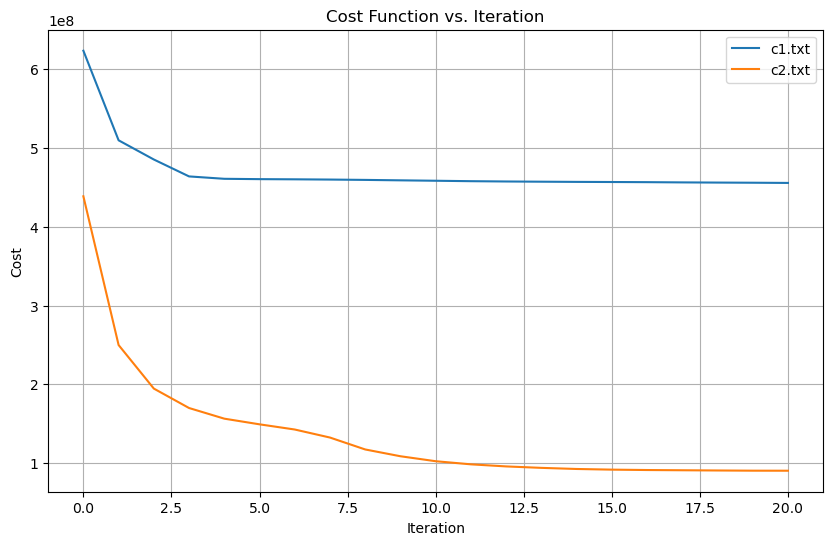

In [4]:
# Define distance function
def distance(point, centroid):
    return np.sum((point - centroid) ** 2)

# K-means function
def k_means(data, initial_centroids):
    centroids = initial_centroids.collect()
    num_iterations = 20
    costs = []

    for i in range(num_iterations + 1):
        # Assign each point to the nearest centroid
        closest_centroid = data.map(lambda point: (np.argmin([distance(point, centroid) for centroid in centroids]), (point, 1)))
        # Update centroids
        new_centroids = closest_centroid.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])).map(lambda x: x[1][0] / x[1][1]).collect()
        # Compute cost
        cost = closest_centroid.map(lambda x: distance(x[1][0], centroids[x[0]])).sum()
        costs.append(cost)
        # Update centroids for next iteration
        centroids = new_centroids
    return costs

# Run k-means for c1.txt
costs_c1 = k_means(lines, c1)

# Run k-means for c2.txt
costs_c2 = k_means(lines, c2)

# Plot the cost function as a function of the iteration number
plt.figure(figsize=(10, 6))
plt.plot(range(len(costs_c1)), costs_c1, label='c1.txt')
plt.plot(range(len(costs_c2)), costs_c2, label='c2.txt')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Run k-means for c1.txt for 10 iterations
costs_c1_10_iterations = k_means(lines, c1)[:11]

# Run k-means for c2.txt for 10 iterations
costs_c2_10_iterations = k_means(lines, c2)[:11]

# Compute percentage change in cost for c1.txt
percentage_change_c1 = ((costs_c1_10_iterations[0] - costs_c1_10_iterations[-1]) / costs_c1_10_iterations[0]) * 100

# Compute percentage change in cost for c2.txt
percentage_change_c2 = ((costs_c2_10_iterations[0] - costs_c2_10_iterations[-1]) / costs_c2_10_iterations[0]) * 100

print("Percentage change in cost over the first 10 iterations:")
print("c1.txt:", percentage_change_c1, "%")
print("c2.txt:", percentage_change_c2, "%")


Percentage change in cost over the first 10 iterations:
c1.txt: 26.48391714456056 %
c2.txt: 76.69795594605947 %


In [48]:
# Define Manhattan distance function
def manhattan_distance(point, centroid):
    return np.sum(np.abs(point - centroid))

# K-means function with Manhattan distance
def k_means_manhattan(data, initial_centroids):
    centroids = initial_centroids.collect()
    num_iterations = 20
    costs = []

    for i in range(num_iterations):
        # Assign each point to the nearest centroid
        closest_centroid = data.map(lambda point: (np.argmin([manhattan_distance(point, centroid) for centroid in centroids]), (point, 1)))
        # Update centroids
        new_centroids = closest_centroid.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])).map(lambda x: x[1][0] / x[1][1]).collect()
        # Compute cost
        cost = closest_centroid.map(lambda x: manhattan_distance(x[1][0], centroids[x[0]])).sum()
        costs.append(cost)
        # Update centroids for next iteration
        centroids = new_centroids

# K-medians function
def k_mediansAlt(data, initial_centroids):
    centroids = initial_centroids.collect()
    num_iterations = 20
    costs = []
    
    # Compute initial cost
    #initial_cost = data.map(lambda point: manhattan_distance(point, centroids[np.argmin([manhattan_distance(point, centroid) for centroid in centroids])])).sum()
    #costs.append(initial_cost)
    
    for i in range(num_iterations):
        # Assign each point to the nearest centroid
        closest_centroid = data.map(lambda point: (np.argmin([manhattan_distance(point, centroid) for centroid in centroids]), point)).groupByKey().mapValues(list)
        # Update centroids
        new_centroids = closest_centroid.map(lambda x: np.median(np.array(x[1]), axis=0)).collect()
        # Compute cost
        cost = closest_centroid.map(lambda x: manhattan_distance(x[1], centroids[x[0]])).sum()
        costs.append(cost)
        # Update centroids for next iteration
        centroids = new_centroids
    return costs
        

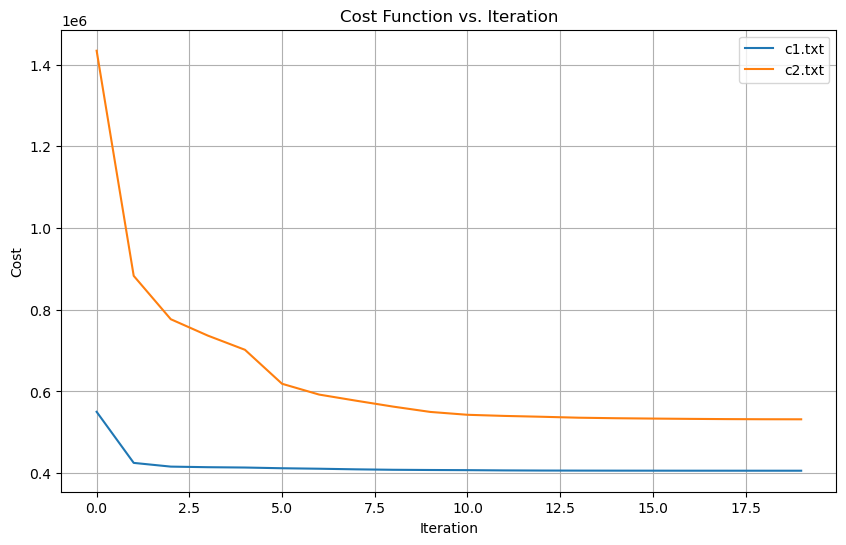

In [49]:
# Run k-means for c1.txt
costs_c1_man = k_mediansAlt(lines, c1)

# Run k-means for c2.txt
costs_c2_man = k_mediansAlt(lines, c2)

# Plot the cost function as a function of the iteration number
plt.figure(figsize=(10, 6))
plt.plot(range(len(costs_c1_man)), costs_c1_man, label='c1.txt')
plt.plot(range(len(costs_c2_man)), costs_c2_man, label='c2.txt')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# Run k-means for c1.txt for 10 iterations
#costs_c1_10_iterations_man = k_means_manhattan(lines, c1)[:12]

# Run k-means for c2.txt for 10 iterations
#costs_c2_10_iterations_man = k_means_manhattan(lines, c2)[:12]

# Compute percentage change in cost for c1.txt
percentage_change_c1_man = ((costs_c1_man[0] - costs_c1_man[11]) / costs_c1_man[0]) * 100

# Compute percentage change in cost for c2.txt
percentage_change_c2_man = ((costs_c2_man[0] - costs_c2_man[11]) / costs_c2_man[0]) * 100

print("Percentage change in cost over the first 10 iterations:")
print("c1.txt:", percentage_change_c1_man, "%")
print("c2.txt:", percentage_change_c2_man, "%")


Percentage change in cost over the first 10 iterations:
c1.txt: 26.065939152283313 %
c2.txt: 62.33228337025927 %


24/04/25 14:49:39 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 888832 ms exceeds timeout 120000 ms
24/04/25 14:49:39 WARN SparkContext: Killing executors is not supported by current scheduler.
24/04/25 14:49:40 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

## Question 3

In [31]:
# Read text files (not using Spark)
user_artist_small_path = '/Users/ekinokos2/Library/CloudStorage/OneDrive-UW/CSE547/hw2-bundle/implicit_feedback/data/user_artists_small.txt'
artists_path = '/Users/ekinokos2/Library/CloudStorage/OneDrive-UW/CSE547/hw2-bundle/implicit_feedback/data/artists.txt'
user_artists_path = '/Users/ekinokos2/Library/CloudStorage/OneDrive-UW/CSE547/hw2-bundle/implicit_feedback/data/user_artists.txt'
user_artists_small_data = pd.read_csv(user_artist_small_path, delimiter='\t')
artists_data = pd.read_csv(artists_path, delimiter='\t')

In [34]:
artists_data.columns

Index(['artistID', 'name'], dtype='object')

In [35]:
user_artists_small_data.columns

Index(['userID', 'artistID', 'interactions'], dtype='object')

In [43]:
# Let's calculate the sparsity ratio: the number of nonzero interactions divided by the number of zero interactions
user_artists_small_data

,userID,artistID,interactions
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983
...,...,...,...
260,94,75,73
261,94,83,45
262,95,59,194
263,96,7,1513


In [42]:
# For each unique artist and for each unique user, calculate the number of interactions
user_artists_small_data.groupby(['userID', 'artistID']).size().reset_index(name='num_interactions')

,userID,artistID,num_interactions
0,0,45,1
1,0,46,1
2,0,47,1
3,0,48,1
4,0,49,1
...,...,...,...
260,94,75,1
261,94,83,1
262,95,59,1
263,96,7,1
